# 14.1a: Thermodynamic Analysis - SGD vs Adam

**Quantifying the cooling and freezing of token dynamics.**

This notebook computes thermodynamic observables for both SGD (13.1a) and Adam (13.1b) training runs to characterize their phase transitions:

1. **Effective Temperature**: RMS velocity (mean squared displacement per step)
2. **Fluctuation Analysis**: Rolling window variance of topological observables
3. **Distance Entropy**: Shannon entropy of pairwise distance distributions

**Hypothesis:**
- SGD: Sharp freeze around step 650 (phase transition)
- Adam: Gradual cooling, freeze around step 1500

## Parameters

In [1]:
# Data sources
SGD_DATA_PATH = "../tensors/Lil_Gatsby/13.1a_training_data.safetensors"
ADAM_DATA_PATH = "../tensors/Lil_Gatsby/13.1b_training_data.safetensors"

# Analysis parameters
WINDOW_SIZE = 100  # For rolling statistics
N_DISTANCE_BINS = 50  # For entropy calculation
MAX_STEPS_TO_PLOT = 2000  # Focus on early dynamics

# Visualization
DPI = 200
COLORMAP = 'inferno'

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import safe_open
from scipy.stats import entropy
from tqdm.auto import tqdm

np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
def load_training_data(path):
    """Load embeddings and convert to float32."""
    with safe_open(path, framework='pt', device='cpu') as f:
        embeddings_bf16 = f.get_tensor('embeddings')
        recorded_steps = f.get_tensor('recorded_steps')
    
    # Convert to float32 for analysis
    embeddings = embeddings_bf16.to(torch.float32)
    
    return embeddings, recorded_steps

print("Loading SGD data...")
sgd_emb, sgd_steps = load_training_data(SGD_DATA_PATH)
print(f"  SGD: {sgd_emb.shape}")

print("\nLoading Adam data...")
adam_emb, adam_steps = load_training_data(ADAM_DATA_PATH)
print(f"  Adam: {adam_emb.shape}")

n_steps, n_tokens, n_dims = sgd_emb.shape

print(f"\n✓ Data loaded")

Loading SGD data...
  SGD: torch.Size([10001, 128, 64])

Loading Adam data...
  Adam: torch.Size([10001, 128, 64])

✓ Data loaded


## 1. Effective Temperature

**Definition:** Mean squared displacement per time step.

$$T_{\text{eff}}(t) = \langle |\mathbf{x}_i(t+1) - \mathbf{x}_i(t)|^2 \rangle_i$$

This measures the typical "kinetic energy" of tokens. High T = hot (tokens moving a lot), low T = cold (frozen).

In [5]:
def compute_effective_temperature(embeddings):
    """
    Compute effective temperature at each step.
    
    Returns:
        T_eff: [n_steps-1] array of mean squared displacement
    """
    # Compute displacements: [n_steps-1, n_tokens, n_dims]
    displacements = embeddings[1:] - embeddings[:-1]
    
    # Square and sum over dimensions: [n_steps-1, n_tokens]
    squared_displacements = (displacements ** 2).sum(dim=2)
    
    # Mean over tokens: [n_steps-1]
    T_eff = squared_displacements.mean(dim=1).numpy()
    
    return T_eff

print("Computing effective temperature...")
sgd_temp = compute_effective_temperature(sgd_emb)
adam_temp = compute_effective_temperature(adam_emb)

print(f"\n✓ Temperature computed")
print(f"  SGD: T_max = {sgd_temp.max():.6f}, T_final = {sgd_temp[-1]:.6f}")
print(f"  Adam: T_max = {adam_temp.max():.6f}, T_final = {adam_temp[-1]:.6f}")

Computing effective temperature...

✓ Temperature computed
  SGD: T_max = 0.000001, T_final = 0.000000
  Adam: T_max = 0.000064, T_final = 0.000000


## 2. Fluctuation Analysis

**Definition:** Rolling window variance of effective temperature.

$$\sigma_T^2(t) = \text{Var}[T_{\text{eff}}(t-w:t)]$$

High variance = system is fluctuating (hot/liquid). Low variance = stable (cold/solid).

In [6]:
def compute_rolling_variance(data, window_size):
    """
    Compute rolling variance with given window size.
    
    Returns:
        variance: [len(data) - window_size + 1] array
    """
    n = len(data)
    variance = np.zeros(n - window_size + 1)
    
    for i in range(len(variance)):
        window = data[i:i+window_size]
        variance[i] = np.var(window)
    
    return variance

print(f"Computing rolling variance (window={WINDOW_SIZE})...")
sgd_var = compute_rolling_variance(sgd_temp, WINDOW_SIZE)
adam_var = compute_rolling_variance(adam_temp, WINDOW_SIZE)

print(f"\n✓ Variance computed")
print(f"  SGD: σ²_max = {sgd_var.max():.8f}")
print(f"  Adam: σ²_max = {adam_var.max():.8f}")

Computing rolling variance (window=100)...

✓ Variance computed
  SGD: σ²_max = 0.00000000
  Adam: σ²_max = 0.00000000


## 3. Distance Entropy

**Definition:** Shannon entropy of the pairwise distance distribution.

$$S(t) = -\sum_i p_i \log p_i$$

where $p_i$ is the probability of finding a token pair at distance bin $i$.

High entropy = many accessible configurations (hot). Low entropy = few configurations (cold/ordered).

In [7]:
def compute_distance_entropy(embeddings, n_bins=50, sample_every=10):
    """
    Compute Shannon entropy of pairwise distance distribution at each step.
    
    Sample every N steps to avoid memory issues.
    """
    n_steps = embeddings.shape[0]
    sampled_steps = range(0, n_steps, sample_every)
    entropies = []
    
    # Get global min/max for consistent binning
    print("  Computing distance range...")
    sample_dists = torch.cdist(embeddings[::100], embeddings[::100], p=2)
    dist_min = sample_dists.min().item()
    dist_max = sample_dists.max().item()
    bins = np.linspace(dist_min, dist_max, n_bins + 1)
    
    print(f"  Computing entropy for {len(sampled_steps)} steps...")
    for step in tqdm(sampled_steps, desc="  Entropy"):
        # Compute pairwise distances
        emb = embeddings[step]
        distances = torch.cdist(emb.unsqueeze(0), emb.unsqueeze(0), p=2)[0]
        
        # Get upper triangle (avoid double-counting)
        triu_indices = torch.triu_indices(n_tokens, n_tokens, offset=1)
        dist_values = distances[triu_indices[0], triu_indices[1]].numpy()
        
        # Histogram
        counts, _ = np.histogram(dist_values, bins=bins)
        
        # Normalize to probability
        probs = counts / counts.sum()
        
        # Shannon entropy (scipy handles zero probabilities)
        S = entropy(probs, base=2)  # Use base 2 for bits
        entropies.append(S)
    
    return np.array(sampled_steps), np.array(entropies)

print("Computing distance entropy for SGD...")
sgd_entropy_steps, sgd_entropy = compute_distance_entropy(sgd_emb, n_bins=N_DISTANCE_BINS)

print("\nComputing distance entropy for Adam...")
adam_entropy_steps, adam_entropy = compute_distance_entropy(adam_emb, n_bins=N_DISTANCE_BINS)

print(f"\n✓ Entropy computed")
print(f"  SGD: S_initial = {sgd_entropy[0]:.3f} bits, S_final = {sgd_entropy[-1]:.3f} bits")
print(f"  Adam: S_initial = {adam_entropy[0]:.3f} bits, S_final = {adam_entropy[-1]:.3f} bits")

Computing distance entropy for SGD...
  Computing distance range...
  Computing entropy for 1001 steps...


  Entropy:   0%|          | 0/1001 [00:00<?, ?it/s]


Computing distance entropy for Adam...
  Computing distance range...
  Computing entropy for 1001 steps...


  Entropy:   0%|          | 0/1001 [00:00<?, ?it/s]


✓ Entropy computed
  SGD: S_initial = 0.000 bits, S_final = 4.276 bits
  Adam: S_initial = 0.000 bits, S_final = 5.040 bits


## Visualizations

### Effective Temperature Comparison

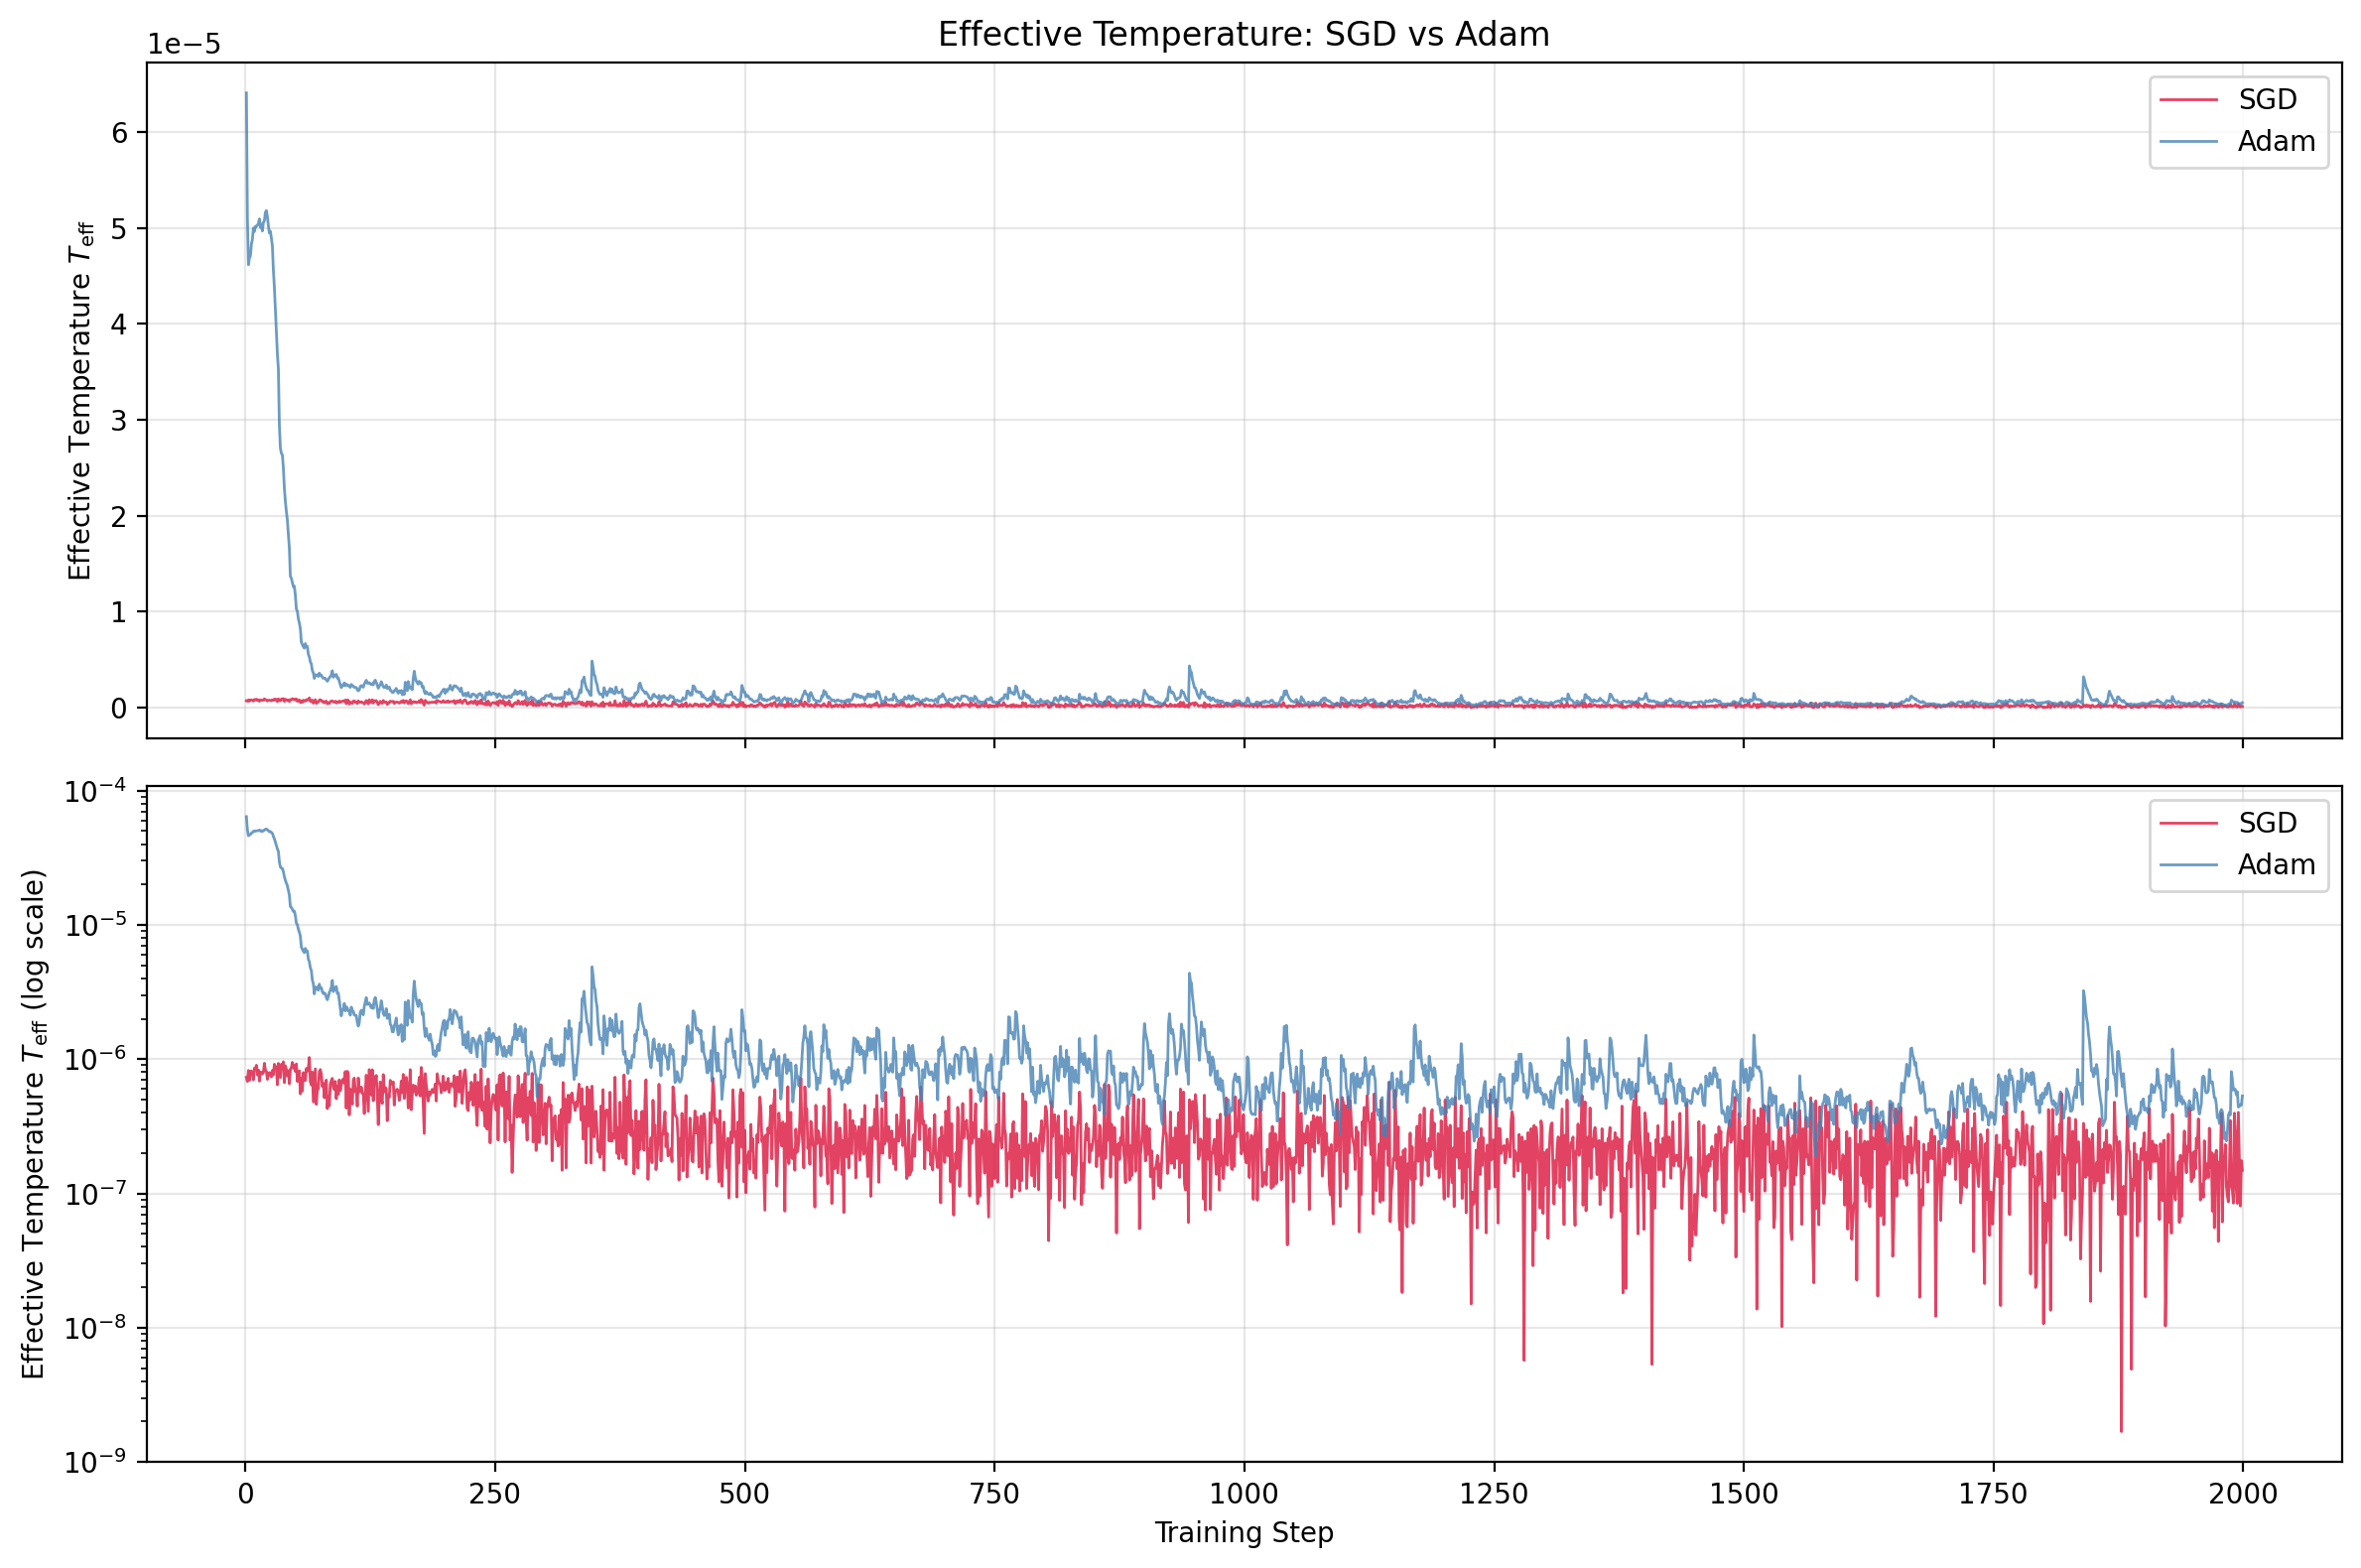

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=DPI, sharex=True)

# Linear scale
ax1.plot(sgd_steps[1:MAX_STEPS_TO_PLOT].numpy(), sgd_temp[:MAX_STEPS_TO_PLOT-1], 
         linewidth=1, color='crimson', label='SGD', alpha=0.8)
ax1.plot(adam_steps[1:MAX_STEPS_TO_PLOT].numpy(), adam_temp[:MAX_STEPS_TO_PLOT-1], 
         linewidth=1, color='steelblue', label='Adam', alpha=0.8)
ax1.set_ylabel('Effective Temperature $T_{\\mathrm{eff}}$')
ax1.set_title('Effective Temperature: SGD vs Adam')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale
ax2.plot(sgd_steps[1:MAX_STEPS_TO_PLOT].numpy(), sgd_temp[:MAX_STEPS_TO_PLOT-1], 
         linewidth=1, color='crimson', label='SGD', alpha=0.8)
ax2.plot(adam_steps[1:MAX_STEPS_TO_PLOT].numpy(), adam_temp[:MAX_STEPS_TO_PLOT-1], 
         linewidth=1, color='steelblue', label='Adam', alpha=0.8)
ax2.set_ylabel('Effective Temperature $T_{\\mathrm{eff}}$ (log scale)')
ax2.set_xlabel('Training Step')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Temperature Fluctuations (Rolling Variance)

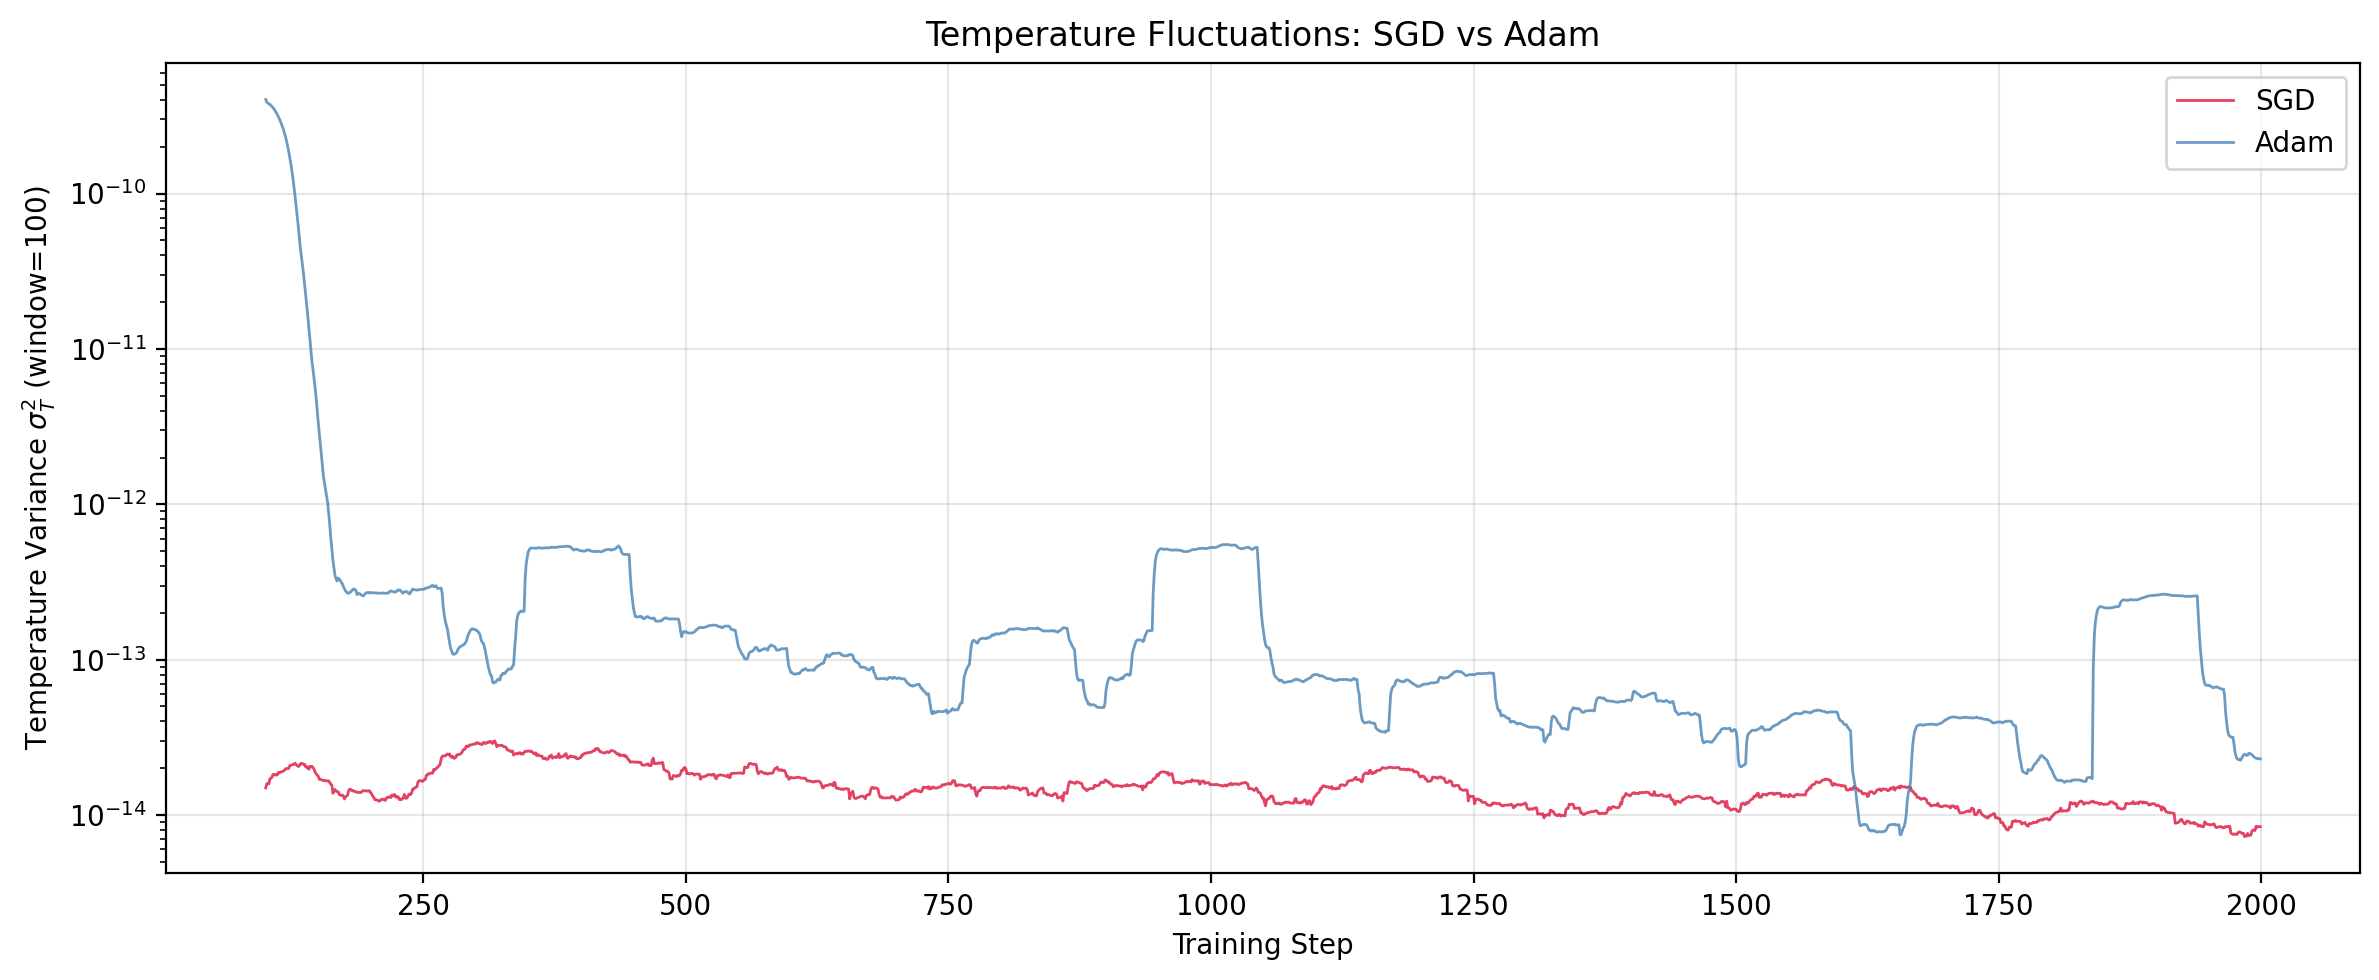

In [9]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

# Steps for variance (shifted by window size)
sgd_var_steps = sgd_steps[WINDOW_SIZE:MAX_STEPS_TO_PLOT].numpy()
adam_var_steps = adam_steps[WINDOW_SIZE:MAX_STEPS_TO_PLOT].numpy()

ax.plot(sgd_var_steps, sgd_var[:MAX_STEPS_TO_PLOT-WINDOW_SIZE], 
        linewidth=1, color='crimson', label='SGD', alpha=0.8)
ax.plot(adam_var_steps, adam_var[:MAX_STEPS_TO_PLOT-WINDOW_SIZE], 
        linewidth=1, color='steelblue', label='Adam', alpha=0.8)

ax.set_xlabel('Training Step')
ax.set_ylabel(f'Temperature Variance $\\sigma^2_T$ (window={WINDOW_SIZE})')
ax.set_title('Temperature Fluctuations: SGD vs Adam')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

### Distance Entropy Evolution

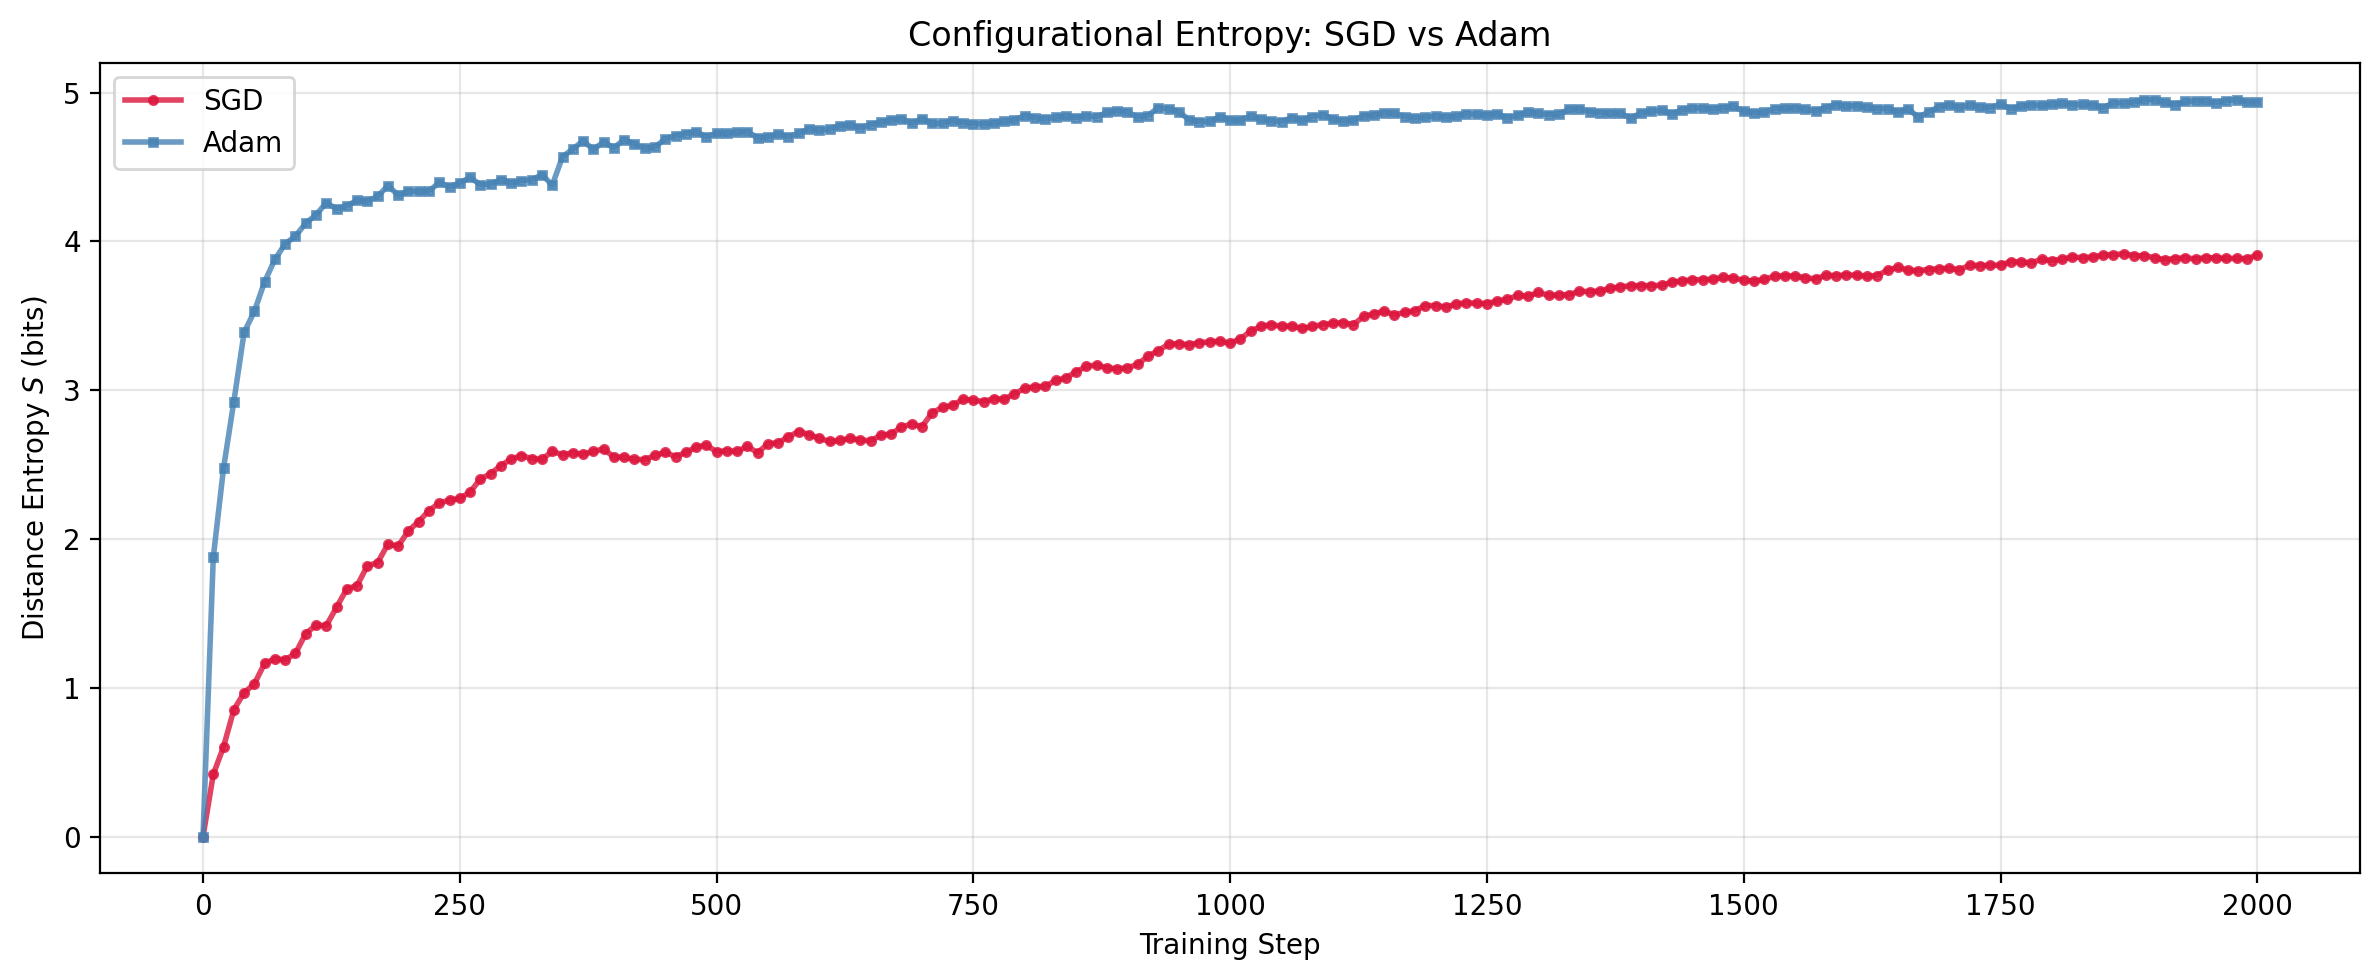

In [10]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

# Only plot up to MAX_STEPS_TO_PLOT
sgd_mask = sgd_entropy_steps <= MAX_STEPS_TO_PLOT
adam_mask = adam_entropy_steps <= MAX_STEPS_TO_PLOT

ax.plot(sgd_entropy_steps[sgd_mask], sgd_entropy[sgd_mask], 
        linewidth=2, color='crimson', label='SGD', marker='o', markersize=3, alpha=0.8)
ax.plot(adam_entropy_steps[adam_mask], adam_entropy[adam_mask], 
        linewidth=2, color='steelblue', label='Adam', marker='s', markersize=3, alpha=0.8)

ax.set_xlabel('Training Step')
ax.set_ylabel('Distance Entropy $S$ (bits)')
ax.set_title('Configurational Entropy: SGD vs Adam')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Summary: Find Phase Transitions

Look for:
1. **Sharp drops in temperature** (freezing)
2. **Collapse of fluctuations** (loss of thermal noise)
3. **Entropy decrease** (loss of accessible states)

In [11]:
print(f"\n{'='*80}")
print(f"PHASE TRANSITION ANALYSIS")
print(f"{'='*80}\n")

# Find steepest temperature drop (second derivative)
def find_steepest_drop(data, steps, max_step=2000):
    """Find step with steepest temperature drop."""
    mask = steps < max_step
    data_masked = data[mask]
    steps_masked = steps[mask]
    
    # Second derivative (acceleration)
    second_deriv = np.diff(np.diff(data_masked))
    
    # Most negative = steepest drop
    steepest_idx = np.argmin(second_deriv)
    
    return steps_masked[steepest_idx+1], second_deriv[steepest_idx]

sgd_transition, sgd_accel = find_steepest_drop(sgd_temp, sgd_steps[1:].numpy())
adam_transition, adam_accel = find_steepest_drop(adam_temp, adam_steps[1:].numpy())

print(f"SGD:")
print(f"  Steepest cooling at step {sgd_transition}")
print(f"  Acceleration: {sgd_accel:.8f}")

print(f"\nAdam:")
print(f"  Steepest cooling at step {adam_transition}")
print(f"  Acceleration: {adam_accel:.8f}")

print(f"\n{'='*80}")


PHASE TRANSITION ANALYSIS

SGD:
  Steepest cooling at step 1145
  Acceleration: -0.00000113

Adam:
  Steepest cooling at step 33
  Acceleration: -0.00000434



## Done

In [12]:
print("✓ Thermodynamic analysis complete")

✓ Thermodynamic analysis complete
